In [1]:
%matplotlib inline
import numpy as np
import time
from sklearn.decomposition import PCA, SparsePCA
from scipy.linalg import svd
import matplotlib.pyplot as plt

# Useful functions

In [2]:
# Helper to define piecewise functions
def piecewise(val,cond):
    return val * cond

# SCAD prox function from Shen's paper. This corresponds exactly to prox of lamb*scad in the conventional sense
def scad(vec, lam, a=3.7):
    return np.multiply(np.multiply(vec - lam * np.sign(vec), np.abs(vec) > lam), np.abs(vec) < (2*lam)) + \
            np.multiply(vec, np.abs(vec) > a * lam) + \
            np.multiply(np.multiply(((a - 1) * vec - np.sign(vec) * lam * a )/ (a - 2), \
                                    np.abs(vec) > (2*lam)), np.abs(vec) < (a*lam))


# Conventional scad objective function
def scad_obj(vec, lamb, a=3.7):
    piece1 = piecewise(lamb*np.abs(vec),np.abs(vec)<=lamb)
    piece2 = piecewise(1/(2*(a-1))*(2*a*lamb*np.abs(vec)-vec**2-lamb**2),np.logical_and(lamb<np.abs(vec),np.abs(vec)<=a*lamb))
    piece3 = piecewise(lamb**2*(a+1)/2,a*lamb<np.abs(vec))
    return np.sum(piece1+piece2+piece3)

# PCA problem
def PCA_obj(Sigma,beta):
    return 1/2*np.linalg.norm(Sigma-np.outer(beta,beta),ord="fro")**2

# L1 regularization
def l1_obj(beta,lamb):
    return lamb*np.sum(np.abs(beta))

# This is the objective function for SCAD regularized PCA
def full_scad_obj(Sigma,beta,lamb,a=3.7):
    return PCA_obj(Sigma,beta)+scad_obj(beta,lamb,a)

# Gradient of pca objective 1/2*||Sigma-beta beta^T||_F^2
def PCA_grad(Sigma,beta):
    return 2*(-np.dot(Sigma,beta)+np.sum(np.square(beta))*beta)

# SCAD = L1 - cvx
# This is the gradient of the -cvx part, so scad grad = l1 gradient + SCAD_ccv_grad
def SCAD_ccv_grad(beta,lamb,a=3.7):
    piece1 = piecewise(0,np.abs(beta)<=lamb)
    piece2 = piecewise(1/(a-1)*(beta-lamb*np.sign(beta)),np.logical_and(lamb<np.abs(beta),np.abs(beta)<=a*lamb))
    piece3 = piecewise(lamb*np.sign(beta),np.abs(beta)>a*lamb)
    return -(piece1+piece2+piece3)

# Proximal operator for L1 (soft thresholding)
def prox_l1(v,c):
    return np.sign(v) * np.maximum(np.abs(v)-c,0)

### Functions for attempted implementation of General Iterative Shrinkage and Thresholding ###
def bb_init(grad_fun,current,previous):
    x = current-previous
    y = grad_fun(current) - grad_fun(previous)
    return np.dot(x,y)/np.dot(x,x)

def line_search_criterion(f,current,previous,t):
    return f(current) <= f(previous) - t/4*np.linalg.norm(current-previous)**2

###

# Soft threshold and project onto the r-ball
def prox_l1_project(v,c,r):
    x = prox_l1(v,c)
    norm = np.linalg.norm(x)
    if norm==0:
        return x
    return x/(np.maximum(1,norm/r))

# Project to unit ball
def l2_project(beta):
    if np.linalg.norm(beta) > 0:
        return beta/np.linalg.norm(beta)
    else:
        return beta

# Squared error between both beta1 and beta2 and the normalized versions
def sq_error(beta1,beta2):
    return np.linalg.norm(beta1-beta2), np.linalg.norm(l2_project(beta1)-l2_project(beta2))

# Sanity check on scad prox function

In [3]:
test = np.random.normal(size=20)
lamb=0.5

In [4]:
prox1=scad(test,lamb)

In [5]:
# Objective in prox function definition
1/2*np.linalg.norm(prox1-test)**2+scad_obj(prox1,lamb)

5.207593030131094

In [6]:
# Confirm that scad(test,lamb) is the optimum
u = np.random.normal(size=prox1.shape[0])
lr=0.01
for _ in range(10000):
    u = u - lr*(u-test+SCAD_ccv_grad(u,lamb))
    u = prox_l1(u,lamb*lr)

In [7]:
np.linalg.norm(prox1-u)

2.0899995089446637e-14

In [8]:
1/2*np.linalg.norm(u-test)**2+scad_obj(u,lamb)

5.207593030131093

# Spiked covariance

In [9]:
# Generates n samples from spiked covariance model of dimension d, spike at u with signal strength gamma
def spiked_cov(n,d,u,gamma=1,return_cov=False):
    u = u / np.linalg.norm(u)
    cov = np.eye(d) + gamma * np.outer(u,u)
    X = np.random.multivariate_normal(np.zeros(d),cov,size=n)
    if return_cov:
        return X, cov
    else:
        return X

# First s entries are 1
def equal_spike(n,d,s,gamma=1,return_cov=False):
    u = np.zeros(d)
    u[:s] = 1
    return spiked_cov(n,d,u,gamma,return_cov)

# First entry is alpha, next s-1 entries are 1
def heavy_spike(n,d,s,gamma=1,alpha=10,return_cov=False):
    u = np.zeros(d)
    u[0] = alpha
    u[1:s] = 1
    return spiked_cov(n,d,u,gamma,return_cov)

In [22]:
n = 100
d = 100
s = 10
np.random.seed(42)
X, pop_cov = heavy_spike(n,d,s,gamma=5,return_cov=True)
Sigma = 1/n*np.dot(X.T,X)

In [35]:
# Leading eigenvector of sample covariance times sqrt eigenvalue
sample_vals, sample_vecs = np.linalg.eigh(Sigma)
sample_vecs[:,d-1]*np.sqrt(sample_vals[d-1])

array([ 2.41627981e+00,  2.06519565e-01,  1.75093779e-01,  2.61637273e-01,
        1.77463012e-01, -4.72506367e-02,  1.96394638e-01,  1.10625715e-01,
        2.35234970e-01,  1.46146266e-01,  1.37219630e-01, -3.05346032e-02,
        5.67655758e-02, -2.26914861e-01, -7.52907805e-02,  4.00911103e-02,
       -8.96410572e-02,  1.12106834e-02, -1.26599486e-01, -3.36469535e-01,
       -2.24135471e-02, -1.00972010e-01, -1.18995106e-04, -1.30202541e-01,
       -3.28144356e-01,  1.67735651e-01, -4.46136110e-02,  8.45234818e-02,
        1.01612748e-01, -3.28839425e-03,  1.77498704e-01, -1.25634518e-02,
       -5.57485953e-02, -6.95376759e-02,  1.90665376e-01,  7.01341546e-02,
        7.60332115e-02, -7.87641397e-02, -1.28248141e-01, -7.63612956e-02,
        2.36822896e-02, -4.09050189e-02,  2.68099056e-02,  2.14701429e-02,
        6.54299381e-02,  1.60711639e-02,  8.27470552e-02, -6.77376773e-02,
        2.41859362e-02, -2.95405163e-01,  2.92010243e-02,  7.17175693e-02,
       -6.51000818e-02,  

In [36]:
pop_vals, pop_vecs = np.linalg.eigh(pop_cov)
pop_vecs[:,d-1]*np.sqrt(pop_vals[d-1])

array([2.34618566, 0.23461857, 0.23461857, 0.23461857, 0.23461857,
       0.23461857, 0.23461857, 0.23461857, 0.23461857, 0.23461857,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [37]:
beta_star = pop_vecs[:,d-1]*np.sqrt(pop_vals[d-1])
beta_star_normalized = pop_vecs[:,d-1]

In [38]:
start = time.time()
spca = SparsePCA(n_components=1, method='cd',normalize_components=True)
SPCAResult = spca.fit(X)
spca_time_result = time.time() - start
SPCAResult.components_

array([[-9.69543073e-01, -4.02086514e-02, -2.23745650e-02,
        -5.49887574e-02, -2.68242859e-02,  0.00000000e+00,
        -2.95379724e-02, -0.00000000e+00, -3.94873997e-02,
        -2.22746832e-02, -3.62691287e-04,  0.00000000e+00,
        -0.00000000e+00,  4.49685616e-02,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         8.48155715e-03,  8.72087822e-02, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         7.26615537e-02, -2.64781501e-02,  0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -1.34412099e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -2.80593259e-02, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  6.55857214e-02, -0.00000000e+0

# SCAD subgradient descent

In [118]:
# Common learning rate and lambda
n_iter = 5000
lr = 0.0002
lamb = 0.5

In [119]:
best_obj = np.inf
objs_gd = np.zeros(n_iter)
for _ in range(1):
    (U, s, Vh) = svd(X)
    # beta = Vh[0]
    np.random.seed(2)
    beta=5*np.random.normal(size=d)
    for i in range(n_iter):
        # Funny-looking learning rate schedule
        # * np.log(i+2)/np.sqrt(2*(i+1))
        beta = beta - lr *(PCA_grad(Sigma,beta)+SCAD_ccv_grad(beta,lamb)+lamb*np.sign(beta))
        objs_gd[i] = full_scad_obj(Sigma,beta,lamb)
    best_obj = np.minimum(best_obj,full_scad_obj(Sigma,beta,lamb))
print(best_obj)

102.94869965447958


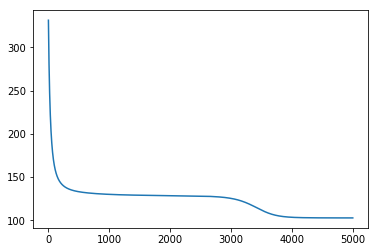

In [120]:
plt.plot(objs_gd)
plt.show()

In [121]:
beta

array([ 2.49322170e+00,  1.73811889e-01,  1.37478466e-01,  2.23738924e-01,
        1.36014515e-01, -2.11537569e-03,  1.57201040e-01,  6.60140139e-02,
        1.93049584e-01,  1.17289363e-01,  8.49480299e-02, -2.56904634e-03,
        1.32267712e-02, -1.87688422e-01, -3.49515935e-02,  1.56757894e-02,
       -4.44412997e-02,  1.02128575e-05, -9.61337295e-02, -2.94921369e-01,
        3.57137034e-05, -5.95396461e-02,  4.73998574e-05, -7.74263954e-02,
       -2.81488008e-01,  1.36712313e-01, -5.39377639e-05,  6.24018942e-02,
        5.85654825e-02, -3.61682746e-06,  1.25964242e-01, -1.84237399e-05,
       -1.18283330e-02, -1.56287489e-02,  1.55675063e-01,  1.52517227e-02,
        2.55172936e-02, -3.11527099e-02, -8.61658381e-02, -2.60034205e-02,
        1.36026502e-04, -9.25873439e-06,  2.63171798e-03, -1.07541235e-06,
        3.28620289e-02,  1.27336695e-05,  4.08156391e-02, -1.66780358e-02,
        8.41752270e-04, -2.50268029e-01,  1.73570816e-04,  2.48771047e-02,
       -2.71363434e-02,  

# Naive prox with scad
this is worse than the others

In [122]:
best_obj = np.inf
objs_scad = np.zeros(n_iter)
for _ in range(1):
    (U, s, Vh) = svd(X)
    #beta = Vh[0]
    np.random.seed(2)
    beta = 5*np.random.normal(size=d)
    for i in range(n_iter):
        # print(SCAD_ccv_grad(beta,lamb))
        beta = beta - lr * PCA_grad(Sigma,beta)
        beta = scad(beta,lr * lamb)
        objs_scad[i] = full_scad_obj(Sigma,beta,lamb)
    best_obj = np.minimum(best_obj,full_scad_obj(Sigma,beta,lamb))
print(best_obj)

103.75512907978298


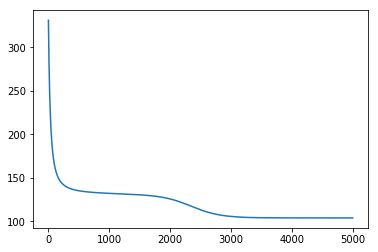

In [123]:
plt.plot(objs_scad)
plt.show()

In [124]:
beta

array([ 2.41742103e+00,  2.07309242e-01,  1.75071824e-01,  2.61772089e-01,
        1.79489575e-01, -3.99929011e-02,  1.95615054e-01,  1.11077142e-01,
        2.37272960e-01,  1.47250021e-01,  1.36885785e-01, -3.28028045e-02,
        6.31266415e-02, -2.27498551e-01, -7.40429542e-02,  4.49964379e-02,
       -9.23830236e-02,  0.00000000e+00, -1.29549355e-01, -3.37573641e-01,
       -2.34199087e-02, -9.75280943e-02, -1.91945866e-03, -1.27177715e-01,
       -3.29079613e-01,  1.69216743e-01, -4.36911998e-02,  8.81704370e-02,
        1.02072049e-01,  0.00000000e+00,  1.80037329e-01, -1.75088914e-02,
       -5.05241507e-02, -6.68610366e-02,  1.91609328e-01,  7.16593141e-02,
        7.11299419e-02, -7.96065189e-02, -1.32562513e-01, -7.65807226e-02,
        2.14658844e-02, -4.33044305e-02,  2.50870895e-02,  0.00000000e+00,
        6.55281942e-02,  0.00000000e+00,  7.80700128e-02, -6.37157560e-02,
        2.71905006e-02, -2.92411187e-01,  3.12081499e-02,  6.97234368e-02,
       -6.03738903e-02,  

In [686]:
# Barzilai-Borwein init attempt, but doesn't currently work
best_obj = np.inf
for _ in range(1):
    (U, s, Vh) = svd(X)
    beta = Vh[0]
    #np.random.seed(2)
    #beta=5*np.random.normal(size=d)
    previous = beta
    beta = beta - lr * PCA_grad(Sigma,beta)
    beta = scad(beta,lr * lamb)
    for i in range(10000):
        t = bb_init(PCA_grad_fn, beta, previous)
        if np.isnan(t) or t==0:
            print("NAN bb init")
            break
        previous=beta
        beta = beta - lr * PCA_grad(Sigma,beta)
        beta = scad(beta,lr * lamb)
        #beta = beta + 0.001 * np.dot(Sigma, beta)
        #beta=beta/np.linalg.norm(beta)
    best_obj = np.minimum(best_obj,full_scad_obj(Sigma,beta,lamb))
print(best_obj)

NAN bb init
5.403546030243136


# Lasso via prox

In [125]:
best_obj = np.inf
for _ in range(1):
    (U, s, Vh) = svd(X)
    #beta = Vh[0]
    np.random.seed(2)
    beta = 5*np.random.normal(size=d)
    for i in range(n_iter):
        beta = beta - lr* (PCA_grad(Sigma,beta))
        beta = prox_l1(beta,lr * lamb)
    best_obj = np.minimum(best_obj,full_scad_obj(Sigma,beta,lamb))
print(best_obj)
# print(beta)
# print(sq_error(beta,beta_star))
# print(full_scad_obj(Sigma,beta,lamb))

102.95275120429623


In [126]:
beta

array([ 2.47346613e+00,  1.74976201e-01,  1.38626713e-01,  2.25532016e-01,
        1.35595483e-01, -1.70160412e-03,  1.57705954e-01,  6.58529423e-02,
        1.95528999e-01,  1.17450474e-01,  8.46711901e-02, -3.77099258e-03,
        1.30421275e-02, -1.88564802e-01, -3.50007453e-02,  1.67835299e-02,
       -4.47239428e-02,  0.00000000e+00, -9.67064491e-02, -2.96675332e-01,
       -0.00000000e+00, -5.99099701e-02, -0.00000000e+00, -7.76082100e-02,
       -2.83590860e-01,  1.37731368e-01, -0.00000000e+00,  6.26015481e-02,
        5.85543889e-02, -0.00000000e+00,  1.25902810e-01, -0.00000000e+00,
       -1.08383942e-02, -1.51196387e-02,  1.56334519e-01,  1.49634037e-02,
        2.51460432e-02, -3.11897235e-02, -8.72860423e-02, -2.58484430e-02,
        0.00000000e+00, -0.00000000e+00,  2.71383353e-03,  0.00000000e+00,
        3.26977482e-02,  0.00000000e+00,  3.99888373e-02, -1.64271160e-02,
        4.44057061e-04, -2.51470270e-01,  0.00000000e+00,  2.45770289e-02,
       -2.65659762e-02,  

# Prox by splitting scad

In [127]:
best_obj = np.inf
objs_split = np.zeros(n_iter)
for _ in range(1):
    (U, s, Vh) = svd(X)
    #beta = Vh[0]
    np.random.seed(2)
    beta = 5*np.random.normal(size=d)
    for i in range(n_iter):
        # print(SCAD_ccv_grad(beta,lamb))
        beta = beta - lr * (PCA_grad(Sigma,beta)+SCAD_ccv_grad(beta,lamb,a=3.7))
        beta = prox_l1(beta,lr * lamb)
        objs_split[i] = full_scad_obj(Sigma,beta,lamb)
    best_obj = np.minimum(best_obj,full_scad_obj(Sigma,beta,lamb))
print(best_obj)
# print(beta)
# print(sq_error(beta,beta_star))
# print(full_scad_obj(Sigma,beta,lamb))

102.94914668651465


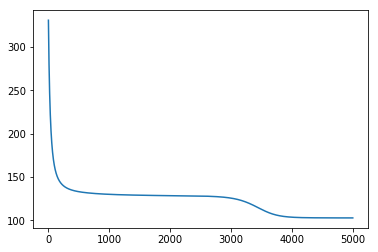

In [128]:
plt.plot(objs_split)
plt.show()

In [129]:
beta

array([ 2.49344617e+00,  1.73767905e-01,  1.37499473e-01,  2.23708783e-01,
        1.35638135e-01, -2.02356028e-03,  1.56975546e-01,  6.57919344e-02,
        1.93315365e-01,  1.17244252e-01,  8.45997881e-02, -3.00852654e-03,
        1.31002413e-02, -1.87625445e-01, -3.49675481e-02,  1.60093030e-02,
       -4.43192987e-02,  0.00000000e+00, -9.61981453e-02, -2.94699073e-01,
       -0.00000000e+00, -5.93743527e-02, -0.00000000e+00, -7.70832348e-02,
       -2.81303100e-01,  1.36717635e-01, -0.00000000e+00,  6.22613412e-02,
        5.84504102e-02, -0.00000000e+00,  1.25599381e-01, -0.00000000e+00,
       -1.15975164e-02, -1.53554490e-02,  1.55605224e-01,  1.50840791e-02,
        2.53291640e-02, -3.10355140e-02, -8.61599495e-02, -2.58706059e-02,
        0.00000000e+00, -0.00000000e+00,  2.71213672e-03,  0.00000000e+00,
        3.28281460e-02,  0.00000000e+00,  4.05596963e-02, -1.64778312e-02,
        9.23932435e-04, -2.49934207e-01,  0.00000000e+00,  2.46651104e-02,
       -2.70254432e-02,  

# Prox with projection

In [130]:
best_obj = np.inf
objs_prox_proj = np.zeros(n_iter)
for _ in range(1):
    (U, s, Vh) = svd(X)
    #beta = Vh[0]
    np.random.seed(2)
    beta = 5*np.random.normal(size=d)
    norm_sigma = np.linalg.norm(Sigma,ord=2)
    for i in range(n_iter):
        beta = beta - lr * (PCA_grad(Sigma,beta))#+SCAD_ccv_grad(beta,lamb,a=3.7))
        beta = prox_l1_project(beta,lr * lamb,norm_sigma)
        objs_prox_proj[i] = full_scad_obj(Sigma,beta,lamb)
    best_obj = np.minimum(best_obj,full_scad_obj(Sigma,beta,lamb))
print(best_obj)
# print(beta)
# print(sq_error(beta,beta_star))
# print(full_scad_obj(Sigma,beta,lamb))

102.95275120429623


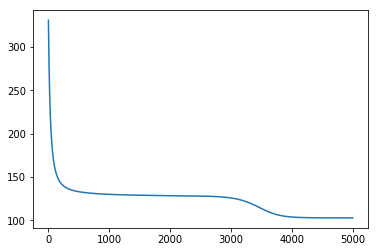

In [131]:
plt.plot(objs_prox_proj)
plt.show()

In [132]:
beta

array([ 2.47346613e+00,  1.74976201e-01,  1.38626713e-01,  2.25532016e-01,
        1.35595483e-01, -1.70160412e-03,  1.57705954e-01,  6.58529423e-02,
        1.95528999e-01,  1.17450474e-01,  8.46711901e-02, -3.77099258e-03,
        1.30421275e-02, -1.88564802e-01, -3.50007453e-02,  1.67835299e-02,
       -4.47239428e-02,  0.00000000e+00, -9.67064491e-02, -2.96675332e-01,
       -0.00000000e+00, -5.99099701e-02, -0.00000000e+00, -7.76082100e-02,
       -2.83590860e-01,  1.37731368e-01, -0.00000000e+00,  6.26015481e-02,
        5.85543889e-02, -0.00000000e+00,  1.25902810e-01, -0.00000000e+00,
       -1.08383942e-02, -1.51196387e-02,  1.56334519e-01,  1.49634037e-02,
        2.51460432e-02, -3.11897235e-02, -8.72860423e-02, -2.58484430e-02,
        0.00000000e+00, -0.00000000e+00,  2.71383353e-03,  0.00000000e+00,
        3.26977482e-02,  0.00000000e+00,  3.99888373e-02, -1.64271160e-02,
        4.44057061e-04, -2.51470270e-01,  0.00000000e+00,  2.45770289e-02,
       -2.65659762e-02,  

# Prox with line search, no scad splitting
(doesn't work rn)

In [637]:
best_obj = np.inf
PCA_grad_fn = lambda x: PCA_grad(Sigma,x)
PCA_obj_fn = lambda x: PCA_obj(Sigma,x)
max_iter=20
for _ in range(1):
    t = 1000
    lamb = 0.3
    (U, s, Vh) = svd(X)
    beta = Vh[0]
    np.random.seed(2)
    beta=5*np.random.normal(size=d)
    previous = beta
    beta = beta - 1/t * PCA_grad(Sigma,beta)
    beta = scad(beta,1/t * lamb)
    for i in range(100):
        t = bb_init(PCA_grad_fn, beta, previous)
        if np.isnan(t) or t==0:
            print("NAN bb init")
            break
        break_cond = False
        iter_count = 0
        while not break_cond and iter_count < max_iter:
            previous = beta
            beta = beta - 1/t * PCA_grad(Sigma,beta)
            beta = scad(beta,1/t * lamb)
            if line_search_criterion(PCA_obj_fn,beta,previous,t):
                print("broke, {0}".format(np.linalg.norm(beta)))
                break_cond=True
            t=1.1*t
            iter_count += 1
            print(np.linalg.norm(beta))
            if np.any(np.isnan(beta)):
                print("NANS IN BETA")
                break
    best_obj = np.minimum(best_obj,full_scad_obj(Sigma,beta,lamb))
print(best_obj)
# print(beta)
# print(sq_error(beta,beta_star))
# print(full_scad_obj(Sigma,beta,lamb))

broke, 3.391048665648886
3.391048665648886
broke, 2.3841853888215025
2.3841853888215025
broke, 1.9283822080144035
1.9283822080144035
broke, 1.5320393477913938
1.5320393477913938
broke, 1.2849718567151571
1.2849718567151571
broke, 1.1327010746859174
1.1327010746859174
broke, 1.0634194404856945
1.0634194404856945
broke, 1.0618050009295472
1.0618050009295472
1.0815302897222947
1.2917844506319514
2.572655967184829
21.8659362738259
12602.823430406172
2194288848347.4817
1.0528801640714031e+37
1.0574058337244187e+111
nan
NANS IN BETA
NAN bb init
nan


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


# Monotone APG
from https://zhouchenlin.github.io/Publications/2015-NIPS-APG.pdf

In [133]:
norm_sigma=np.linalg.norm(Sigma,ord=2)
print(norm_sigma)

7.75046721922998


In [134]:
np.random.seed(2)
x_curr = 5*np.random.normal(size=d)
x_prev = x_curr
z = x_curr
t_prev = 0
t_curr = 1
lr_x = lr
lr_y = lr
objs_apg = np.zeros(n_iter)
for i in range(n_iter):
    y = x_curr + t_prev/t_curr*(z-x_curr) + (t_prev -1)/t_curr*(x_curr-x_prev)
    z = prox_l1_project(y-lr_y * (PCA_grad(Sigma,y)+SCAD_ccv_grad(y,lamb,a=3.7)),lr*lamb,norm_sigma)
    v = prox_l1_project(x_curr-lr_x * (PCA_grad(Sigma,x_curr)+SCAD_ccv_grad(x_curr,lamb,a=3.7)),lr*lamb,norm_sigma)
    t_prev = t_curr
    t_curr = 1/2*(np.sqrt(4*t_curr**2+1)+1)
    x_prev = x_curr
    obj_z = full_scad_obj(Sigma,z,lamb,a=3.7)
    obj_v = full_scad_obj(Sigma,v,lamb,a=3.7)
    if  obj_z <= obj_v:
        x_curr = z
    else:
        x_curr = v
    objs_apg[i] = min(obj_z,obj_v)
print(full_scad_obj(Sigma,x_curr,lamb,a=3.7))

102.94213875546033


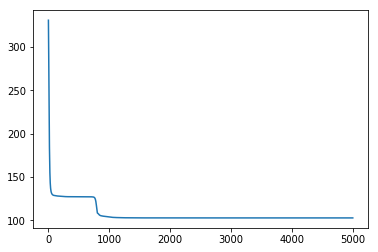

In [135]:
plt.plot(objs_apg)
plt.show()

In [136]:
x_curr

array([ 2.48790324e+00,  1.73664940e-01,  1.35838298e-01,  2.24544274e-01,
        1.42157267e-01, -4.70034543e-03,  1.59605952e-01,  6.98760689e-02,
        1.87904128e-01,  1.16683289e-01,  9.19258440e-02, -0.00000000e+00,
        1.52319424e-02, -1.88526042e-01, -3.35714886e-02,  8.19009454e-03,
       -4.65930394e-02,  0.00000000e+00, -9.35136266e-02, -2.99415428e-01,
       -0.00000000e+00, -6.27351302e-02, -0.00000000e+00, -8.54208339e-02,
       -2.84888446e-01,  1.36567735e-01, -0.00000000e+00,  6.18703010e-02,
        6.00640759e-02, -0.00000000e+00,  1.32694207e-01, -0.00000000e+00,
       -1.67004126e-02, -2.20288954e-02,  1.56286070e-01,  1.89734408e-02,
        2.94229795e-02, -3.44424425e-02, -8.58558220e-02, -2.84281978e-02,
        0.00000000e+00, -0.00000000e+00,  4.28426761e-04,  0.00000000e+00,
        3.27754117e-02,  0.00000000e+00,  4.66721700e-02, -2.14568736e-02,
        0.00000000e+00, -2.56208754e-01,  0.00000000e+00,  2.84913218e-02,
       -2.82893817e-02,  

# Compare optimizers

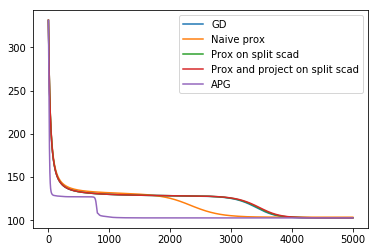

In [137]:
plt.plot(objs_gd,label="GD")
plt.plot(objs_scad,label="Naive prox")
plt.plot(objs_split, label="Prox on split scad")
plt.plot(objs_prox_proj, label="Prox and project on split scad")
plt.plot(objs_apg, label="APG")
plt.legend()
plt.show()

# Prox-MCP

In [435]:
def MCP_ccv_grad(beta,lamb,a=3.7):
    piece1 = piecewise(beta/a,np.abs(beta)<=a*lamb)
    piece2 = piecewise(lamb*np.sign(beta),a*lamb<np.abs(beta))
    return -(piece1+piece2)

In [527]:
lr = 0.001
lamb = 1
(U, s, Vh) = svd(X)
beta = Vh[0]
np.random.seed(2)
beta = np.random.normal(size=d)
for i in range(1000):
    # print(SCAD_ccv_grad(beta,lamb))
    beta = beta - lr * (PCA_grad(Sigma,beta)+MCP_ccv_grad(beta,lamb))
    beta = prox(beta,lr * lamb)
    #beta = beta + 0.001 * np.dot(Sigma, beta)
    #beta=beta/np.linalg.norm(beta)
print(beta)
print(sq_error(beta,beta_star))
print(full_scad_obj(Sigma,beta,lamb))

[-0.00217104 -0.18443326 -0.98832102 -0.          0.          0.
 -0.          0.          0.         -0.        ]
(1.5157258896572714, 0.8065851332307675)
13.331881424694986


In [327]:
l2_project(beta)

array([ 9.99983578e-01,  5.68058341e-03,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  7.58097185e-04])

# Misc: Sparse linear regression with scad

In [162]:
X = np.random.multivariate_normal(np.zeros(6),np.eye(6),size=500)
beta_star = np.array([1,2,3,0,0,0])
Y = np.dot(X,beta_star) + np.random.normal(scale=.2,size=500)

In [163]:
# LASSO
lr = 0.01
lamb = 0.25
samp_cov = np.dot(X.T,X)
xty = np.dot(X.T,Y)
beta = np.array([0.1,-0.1,0.2,0.1,0.3,-0.4])
for i in range(10000):
    beta = beta - lr * 1/500 *(np.dot(samp_cov,beta)-xty)
    beta = prox_l1(beta,lr * lamb)

In [164]:
beta

array([ 0.78524267,  1.75141246,  2.75215731, -0.        , -0.        ,
        0.        ])

In [331]:
# Splitting SCAD
lr = 0.005
lamb = 2.0
samp_cov = np.dot(X.T,X)
xty = np.dot(X.T,Y)
beta = np.array([0.1,-0.1,0.2,0.1,0.3,-0.4])
for i in range(10000):
    beta = beta - lr * 1/500 *(np.dot(samp_cov,beta)-xty)-lr*SCAD_ccv_grad(beta,lamb)
    beta = prox_l1(beta,lr * lamb)
beta

array([ 0.        ,  0.        ,  1.11128046, -0.        , -0.        ,
        0.        ])

In [188]:
for i in range(10000):
    beta = beta - lr * 1/500 *(np.dot(samp_cov,beta)-xty)-lr*SCAD_ccv_grad(beta,lamb)-lr*lamb*np.sign(beta)
    #beta = prox_l1(beta,lr * lamb)
beta

array([7.45906196e-01, 2.01064033e+00, 2.99311056e+00, 2.06921367e-03,
       2.12678680e-03, 1.31704565e-03])

In [326]:
obj = lambda b: 1/500*1/2*np.linalg.norm(Y-np.dot(X,b))**2+scad_obj(b,lamb)

In [325]:
# Prox gradient with scad, this actually works for debiasing (but check the scad penalty?)
lr = 0.005
lamb = 2.0
samp_cov = np.dot(X.T,X)
xty = np.dot(X.T,Y)
beta = np.array([0.1,-0.1,0.2,0.1,0.3,-0.4])
for i in range(40000):
    beta = beta - lr * 1/500 *(np.dot(samp_cov,beta)-xty)
    beta = scad(beta,lr * lamb)
beta

array([1.07056019, 0.        , 2.9442825 , 0.        , 0.        ,
       0.        ])

In [169]:
1/500 *(np.dot(samp_cov,beta)-xty)+lamb*np.sign(beta)+SCAD_ccv_grad(beta,lamb)

array([ 1.73903557e-01, -2.20379270e-14, -2.18158824e-14,  1.45493963e-02,
        3.77988139e-03, -6.30405051e-03])

In [650]:
best_obj = np.inf
samp_cov = np.dot(X.T,X)
xty = np.dot(X.T,Y)
reg_grad_fn = lambda x: np.dot(samp_cov,x)-xty
reg_obj_fn = lambda x: np.linalg.norm(Y-np.dot(X,x))**2
max_iter=100
for _ in range(1):
    t = 1000
    lamb = 0.3
    (U, s, Vh) = svd(X)
    beta = Vh[0]
    np.random.seed(2)
    beta = np.array([0.1,-0.1,0.2,0.1,0.3,-0.4])
    previous = beta
    beta = beta - 1/t * (np.dot(samp_cov,beta)-xty)
    beta = scad(beta,1/t * lamb)
    for i in range(1000):
        t = bb_init(reg_grad_fn, beta, previous)
        if np.isnan(t):
            print("NAN bb init")
            break
        elif t==0:
            print("bb init 0")
            break
        break_cond = False
        iter_count = 0
        while not break_cond and iter_count < max_iter:
            previous = beta
            beta = beta - 1/t * (np.dot(samp_cov,beta)-xty)
            beta = scad(beta,1/t * lamb)
            if line_search_criterion(reg_obj_fn,beta,previous,t):
                print("broke, {0}".format(np.linalg.norm(beta)))
                break_cond=True
            t=1.1*t
            iter_count += 1
            if np.any(np.isnan(beta)):
                print("NANS IN BETA")
                break
    #best_obj = np.minimum(best_obj,full_scad_obj(Sigma,beta,lamb))
print(beta)
# print(beta)
# print(sq_error(beta,beta_star))
# print(full_scad_obj(Sigma,beta,lamb))

broke, 3.716602567406442
broke, 3.721294375885585
broke, 3.73000152185959
broke, 3.729755360482138
broke, 3.7298553162638846
broke, 3.729864291034363
broke, 3.729865654828984
broke, 3.729865330947997
broke, 3.729865333555754
broke, 3.72986533365697
broke, 3.7298653336816594
broke, 3.7298653336818393
broke, 3.7298653336819143
broke, 3.7298653336819143
broke, 3.7298653336819143
broke, 3.7298653336819143
broke, 3.7298653336819143
broke, 3.7298653336819143
broke, 3.7298653336819143
bb init 0
[ 9.88477106e-01  2.00049983e+00  2.98875072e+00  2.93111780e-03
 -3.68254499e-03  1.24825653e-02]
